In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
from scipy.stats import chi2_contingency

### Step 1: Load and Review the dataset

In [2]:
dairy_data= pd.read_excel('./data/dairy_data_cleaned.xlsx')

In [3]:
dairy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Location                             4325 non-null   object        
 1   Total Land Area (acres)              4325 non-null   float64       
 2   Number of Cows                       4325 non-null   int64         
 3   Farm Size                            4325 non-null   object        
 4   Date                                 4325 non-null   datetime64[ns]
 5   Product ID                           4325 non-null   int64         
 6   Product Name                         4325 non-null   object        
 7   Brand                                4325 non-null   object        
 8   Quantity (liters/kg)                 4325 non-null   float64       
 9   Price per Unit                       4325 non-null   float64       
 10  Total Value 

In [4]:
dairy_data.head()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Revenue_per_Unit
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03,82.24
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10,39.24
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83,33.81
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68,28.92
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40,83.07


### Define Target

In [5]:
# Define your four revenue columns
rev_cols = ["Approx. Total Revenue(INR)", 
            "Total Value"]

dairy_data[rev_cols].head()

,Approx. Total Revenue(INR),Total Value
0,575.68,19064.1280
1,21895.92,29293.5228
2,8655.36,18377.0200
3,17380.92,21835.5072
4,12045.15,12390.5145


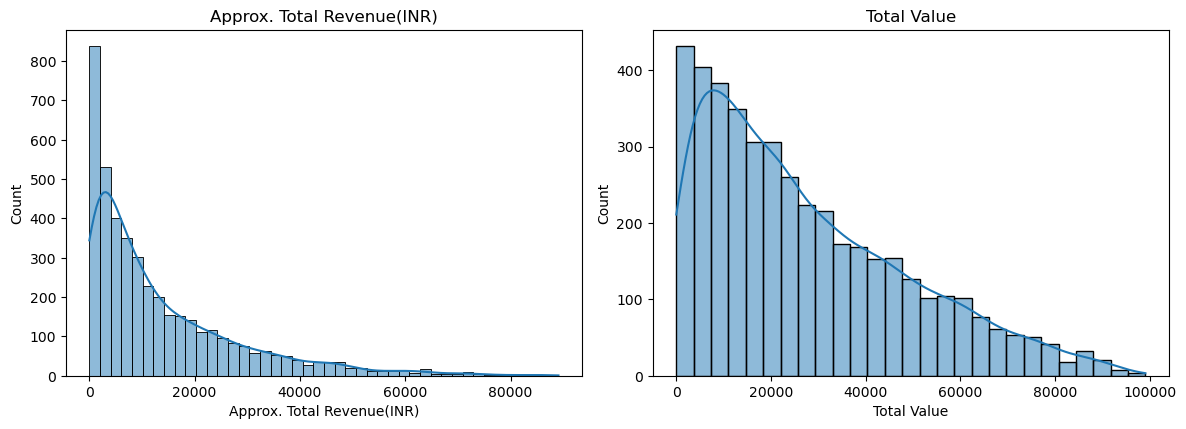

In [6]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(rev_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(dairy_data[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

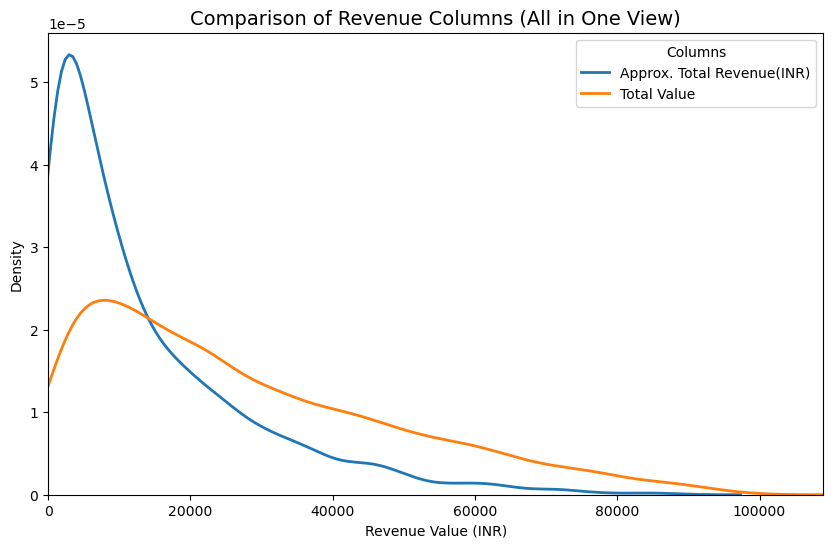

In [7]:
plt.figure(figsize=(10,6))

# Plot all 4 columns on the same axis
for col in ["Approx. Total Revenue(INR)", 
            "Total Value"]:
    sns.kdeplot(data=dairy_data, x=col, fill=False, label=col, linewidth=2)

plt.title("Comparison of Revenue Columns (All in One View)", fontsize=14)
plt.xlabel("Revenue Value (INR)")
plt.ylabel("Density")
plt.legend(title="Columns")
plt.xlim(0, dairy_data["Total Value"].max() * 1.1)  # adjust x-axis range
plt.show()

In [8]:
# Primary target variable: sales revenue (money earned)
target = "Approx. Total Revenue(INR)"

# Important related variable: total inventory value (stock worth)
key_feature_inventory = "Total Value"

print(f"Target variable set to: {target}")
print(f"Inventory-related feature retained as: {key_feature_inventory}")

Target variable set to: Approx. Total Revenue(INR)
Inventory-related feature retained as: Total Value


### Target Variable Selection Summary

**Target Variable:** `Approx. Total Revenue (INR)`  
This column represents the **actual sales revenue** generated from the sale of dairy products.  
It captures the *true business outcome* — how much income was earned from customers.  
Therefore, it will serve as the **primary target variable** for Exploratory Data Analysis (EDA) and later modeling.

---

**Key Supporting Feature:** `Total Value`  
This column represents the **total worth of available stock (inventory)**.  
It provides context for understanding how inventory levels relate to revenue performance.  
Although not the target, it will be **retained as an important explanatory feature** for correlation and relationship analysis.

In [9]:
# Separate features by data type
num_cols = dairy_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = dairy_data.select_dtypes(include=['object']).columns.tolist()
date_cols = dairy_data.select_dtypes(include=['datetime64[ns]']).columns.tolist()

# Remove target from numeric columns (if present)
if target in num_cols:
    num_cols.remove(target)

print("\nNumerical Columns (excluding target):", num_cols)
print("\nCategorical Columns:", cat_cols)
print("\nDate Columns:", date_cols)


Numerical Columns (excluding target): ['Total Land Area (acres)', 'Number of Cows', 'Product ID', 'Quantity (liters/kg)', 'Price per Unit', 'Total Value', 'Shelf Life (days)', 'Quantity Sold (liters/kg)', 'Price per Unit (sold)', 'Quantity in Stock (liters/kg)', 'Minimum Stock Threshold (liters/kg)', 'Reorder Quantity (liters/kg)', 'Revenue_per_Unit']

Categorical Columns: ['Location', 'Farm Size', 'Product Name', 'Brand', 'Storage Condition', 'Customer Location', 'Sales Channel']

Date Columns: ['Date', 'Production Date', 'Expiration Date']


### Step 2: Build Data Profiles and Tables

In [10]:
# Descriptive Statistics for Numerical Columns ===
print("📊 Descriptive Statistics (Numerical Features):\n")
display(dairy_data[num_cols].describe().T)  # Transposed for readability

# === Summary for Categorical Columns ===
print("\n Categorical Features Summary:\n")
for col in cat_cols:
    print(f"Column: {col}")
    print(f"Unique values: {dairy_data[col].nunique()}")
    print(dairy_data[col].value_counts().head(5))
    print("-" * 60)

📊 Descriptive Statistics (Numerical Features):



,count,mean,std,min,25%,50%,75%,max
Total Land Area (acres),4325.0,503.483073,285.935061,10.1700,252.9500,509.1700,751.250,999.5300
Number of Cows,4325.0,54.963699,26.111487,10.0000,32.0000,55.0000,77.000,100.0000
Product ID,4325.0,5.509595,2.842979,1.0000,3.0000,6.0000,8.000,10.0000
Quantity (liters/kg),4325.0,500.652657,288.975915,1.1700,254.1700,497.5500,749.780,999.9300
Price per Unit,4325.0,54.785938,26.002815,10.0300,32.4600,54.4000,77.460,99.9900
Total Value,4325.0,27357.845411,21621.051594,42.5165,9946.8145,21869.6529,40954.441,99036.3696
Shelf Life (days),4325.0,29.127630,30.272114,1.0000,10.0000,22.0000,30.000,150.0000
Quantity Sold (liters/kg),4325.0,248.095029,217.024182,1.0000,69.0000,189.0000,374.000,960.0000
Price per Unit (sold),4325.0,54.779140,26.192790,5.2100,32.6400,54.1400,77.460,104.5100
Quantity in Stock (liters/kg),4325.0,252.068671,223.620870,0.0000,66.0000,191.0000,387.000,976.0000



 Categorical Features Summary:

Column: Location
Unique values: 15
Location
Delhi            525
Chandigarh       519
Uttar Pradesh    276
Gujarat          267
Karnataka        261
Name: count, dtype: int64
------------------------------------------------------------
Column: Farm Size
Unique values: 3
Farm Size
Large     1462
Medium    1439
Small     1424
Name: count, dtype: int64
------------------------------------------------------------
Column: Product Name
Unique values: 10
Product Name
Curd          479
Lassi         447
Paneer        441
Yogurt        437
Buttermilk    435
Name: count, dtype: int64
------------------------------------------------------------
Column: Brand
Unique values: 11
Brand
Amul            1053
Mother Dairy    1010
Raj              685
Sudha            648
Dodla Dairy      222
Name: count, dtype: int64
------------------------------------------------------------
Column: Storage Condition
Unique values: 5
Storage Condition
Refrigerated        2459
Frozen   

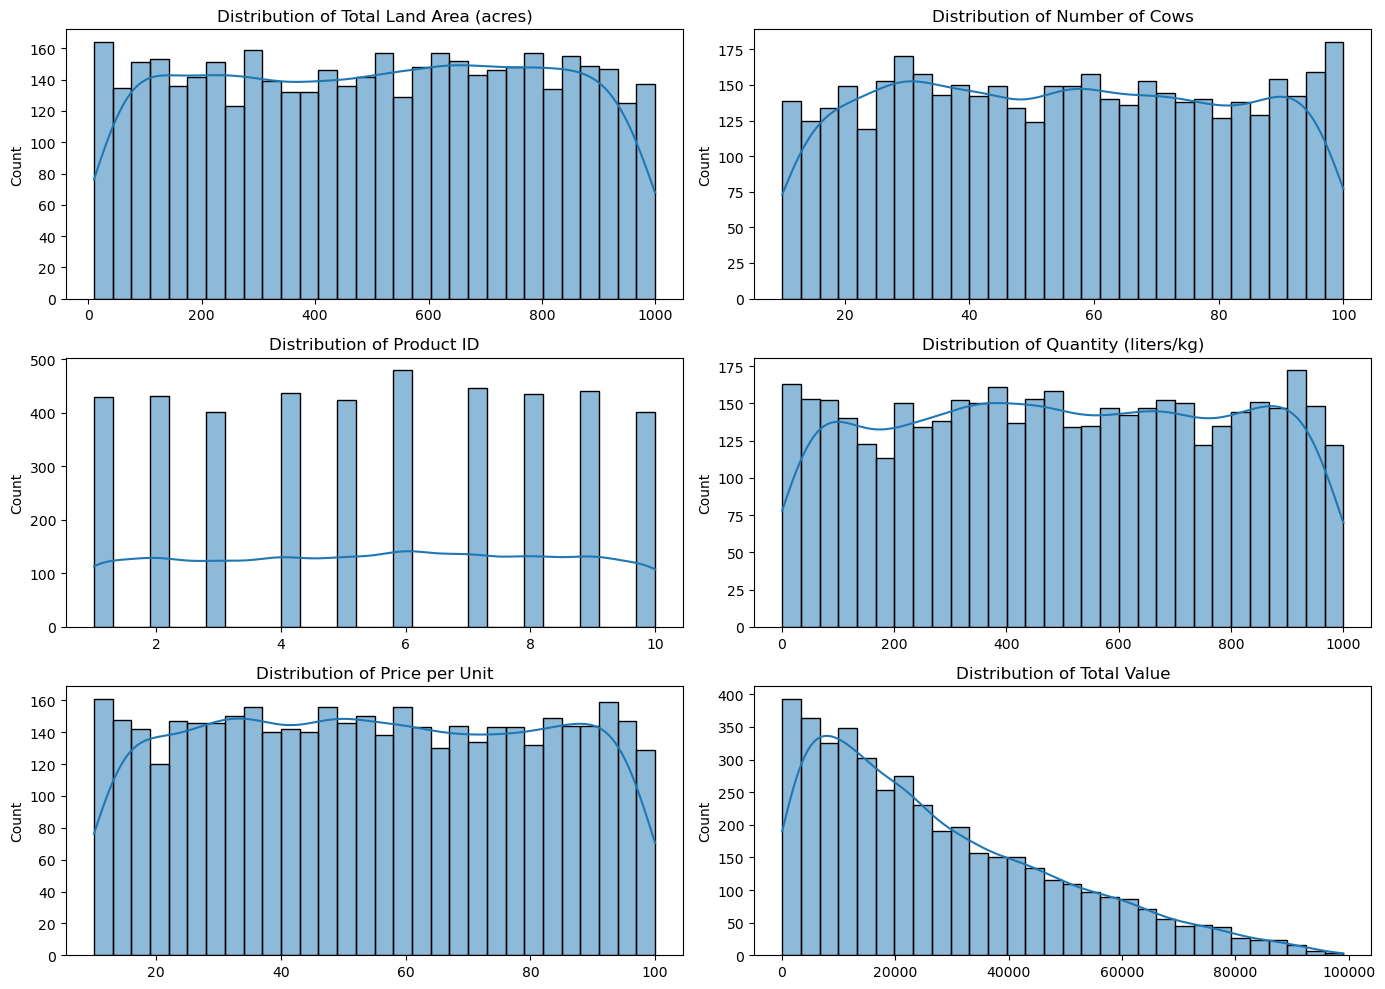

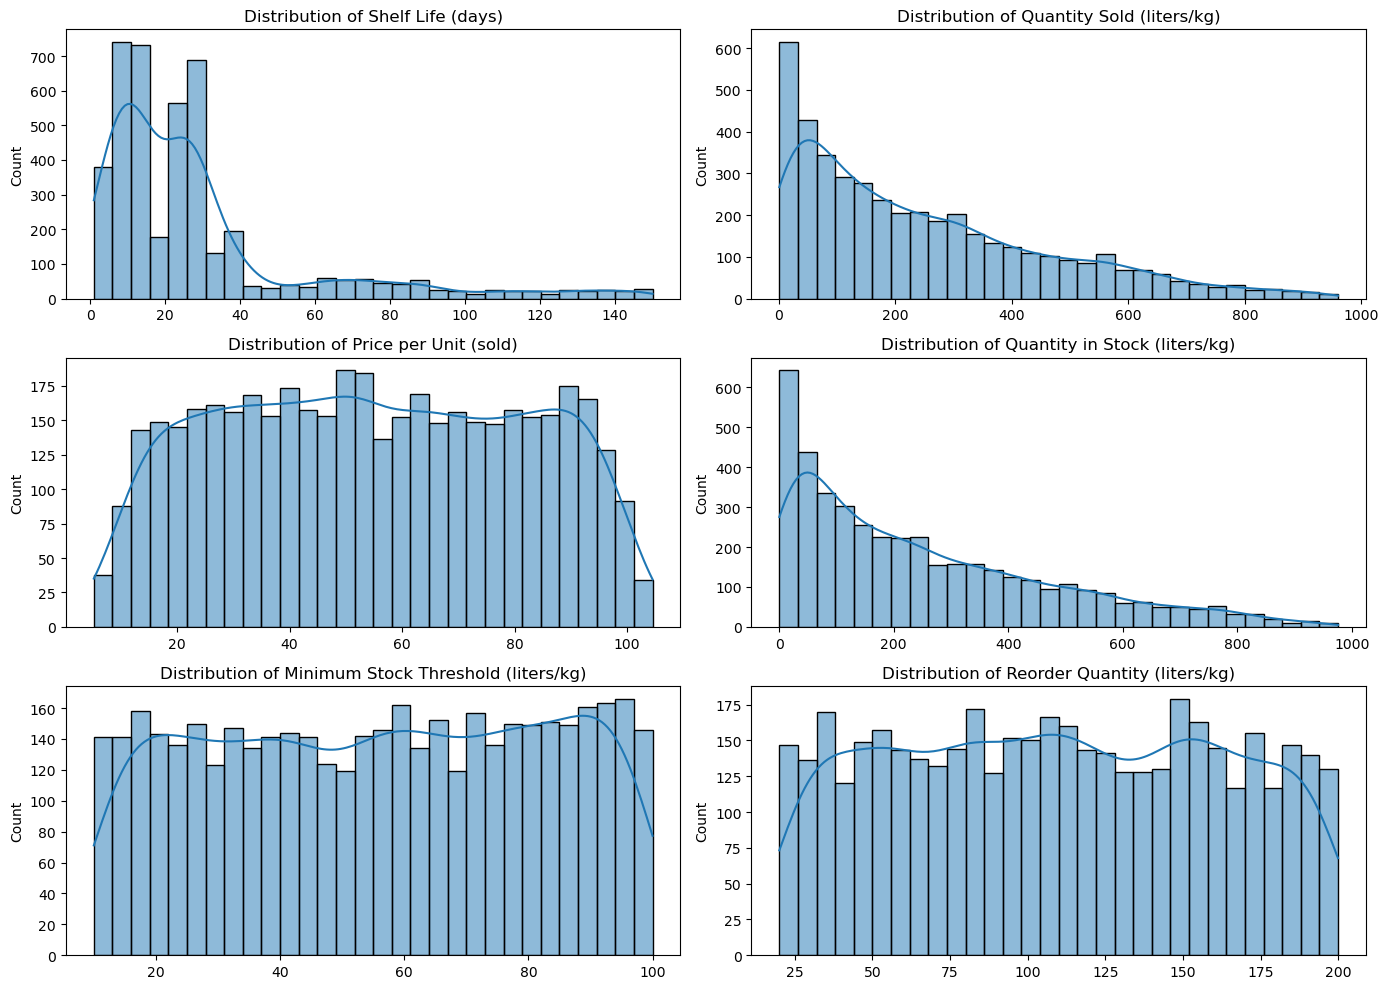

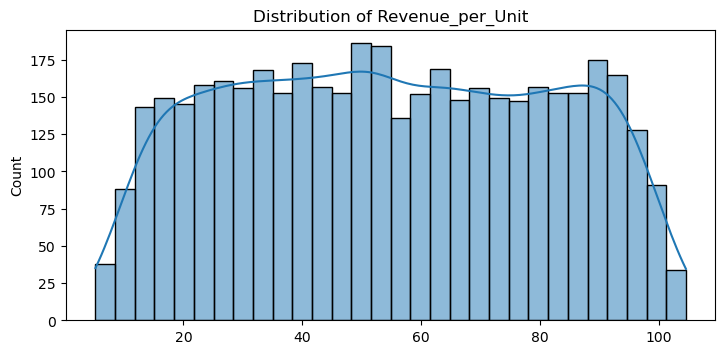

In [11]:
# Loop through all numeric columns in chunks of 6
for start in range(0, len(num_cols), 6):
    plt.figure(figsize=(14, 10))
    
    # Take a slice of 6 columns at a time
    subset = num_cols[start:start+6]
    
    for i, col in enumerate(subset, 1):
        plt.subplot(3, 2, i)
        sns.histplot(dairy_data[col], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel("")
        plt.ylabel("Count")
    
    plt.tight_layout()
    plt.show()

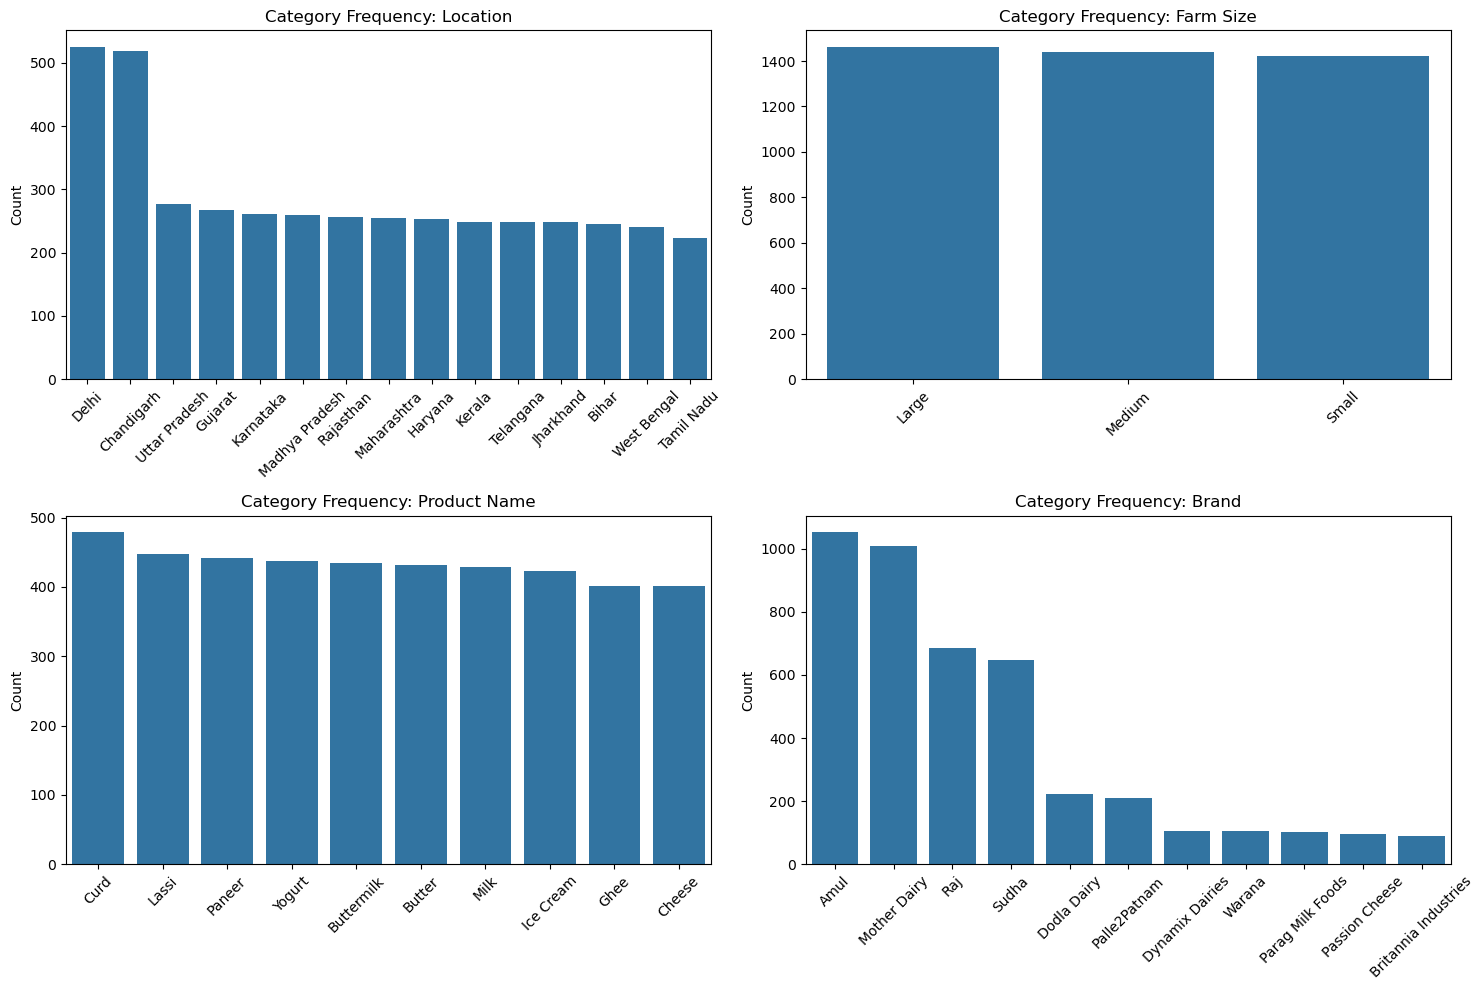

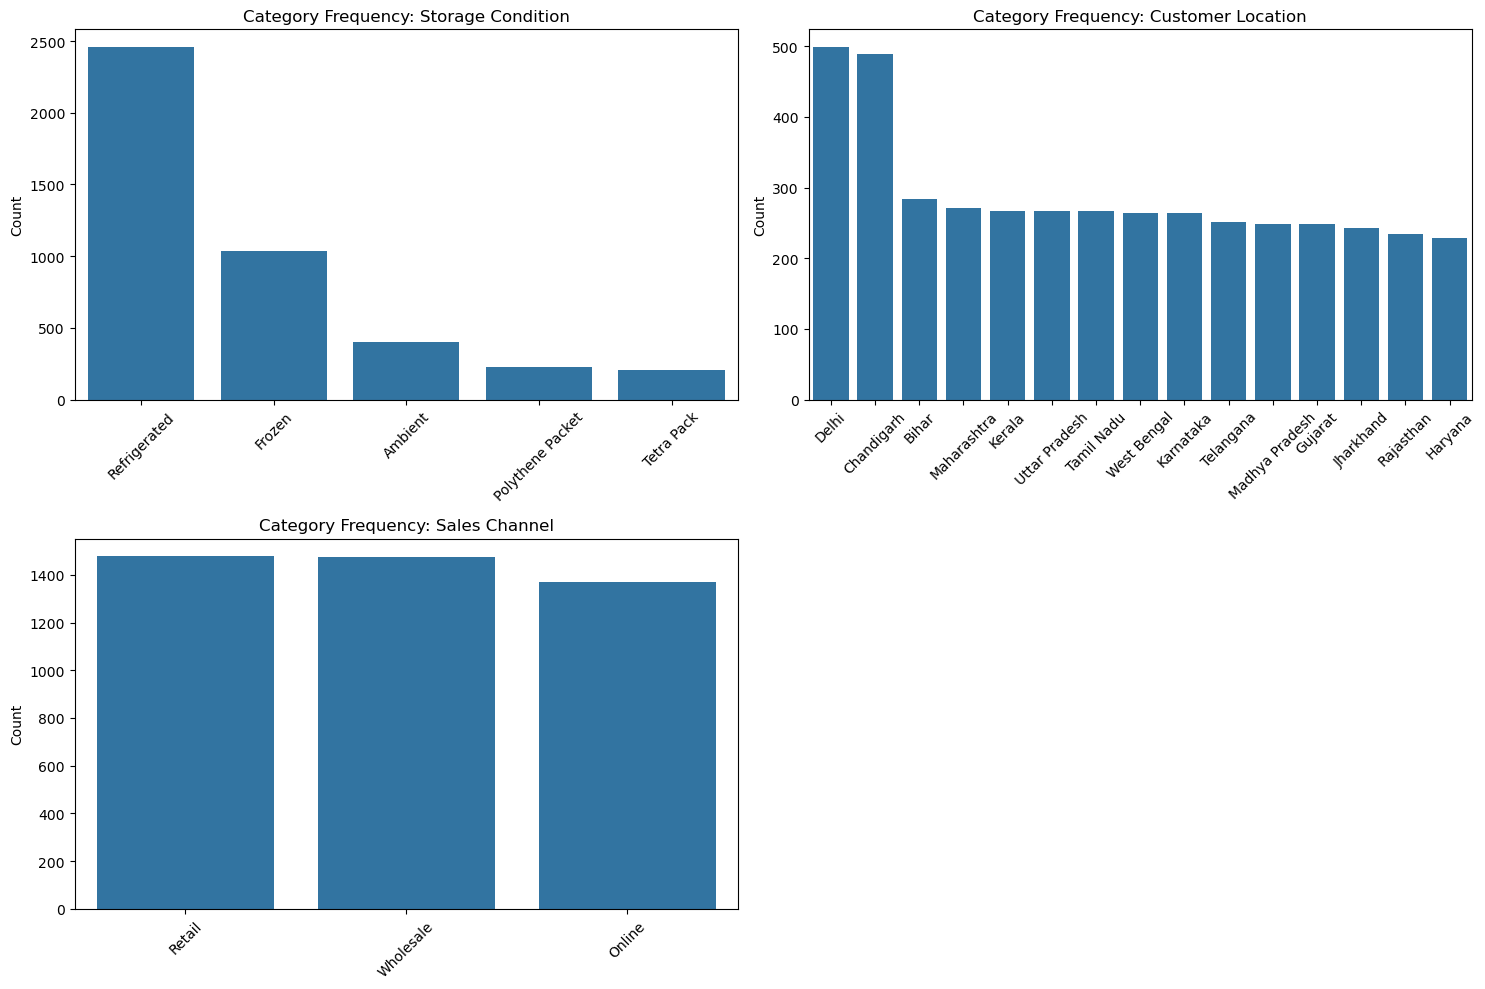

In [12]:
# Use all categorical columns
cat_to_plot = cat_cols  # all from your earlier type separation

# Loop through all categorical columns, 4 per figure (2×2 layout)
for start in range(0, len(cat_to_plot), 4):
    subset = cat_to_plot[start:start+4]
    plt.figure(figsize=(15, 10))

    for i, col in enumerate(subset, 1):
        plt.subplot(2, 2, i)
        sns.countplot(data=dairy_data, x=col, order=dairy_data[col].value_counts().index)
        plt.title(f"Category Frequency: {col}")
        plt.xticks(rotation=45)
        plt.xlabel("")
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

### Decision: Drop `Product ID`

`Product ID` is a numeric identifier used only to label different products.  
It does not carry any quantitative or ordinal meaning — the numeric values (1, 2, 3, …) are arbitrary and do not represent any measurable relationship.

- The distribution is uniform across IDs, confirming no business or statistical significance.  
- Including it in correlation or modeling would **mislead algorithms**, as models may wrongly interpret higher IDs as higher values.  
- The actual product information is already captured in `Product Name`, which is more meaningful for analysis.

Therefore, `Product ID` is **dropped** from further analysis and modeling.

In [13]:
dairy_data = dairy_data.drop(columns=['Product ID'])
dairy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Location                             4325 non-null   object        
 1   Total Land Area (acres)              4325 non-null   float64       
 2   Number of Cows                       4325 non-null   int64         
 3   Farm Size                            4325 non-null   object        
 4   Date                                 4325 non-null   datetime64[ns]
 5   Product Name                         4325 non-null   object        
 6   Brand                                4325 non-null   object        
 7   Quantity (liters/kg)                 4325 non-null   float64       
 8   Price per Unit                       4325 non-null   float64       
 9   Total Value                          4325 non-null   float64       
 10  Shelf Life (

### Step 2 Summary — Key Insights

- Several numeric columns (e.g., `Total Value`, `Quantity Sold`) are **right-skewed** → apply log or scaling before modeling.  
- Clear **dominance** in some categories:
  - Brands: *Amul* and *Mother Dairy* lead.  
  - Storage: mostly *Refrigerated* items.  
  - Locations: mainly *Delhi* and *Chandigarh*.  
→ Focus tests on these to see if dominance impacts revenue.

- **Sales Channels** are balanced → good for mean comparison tests (e.g., ANOVA). 

### Step 3: Feature Engineering

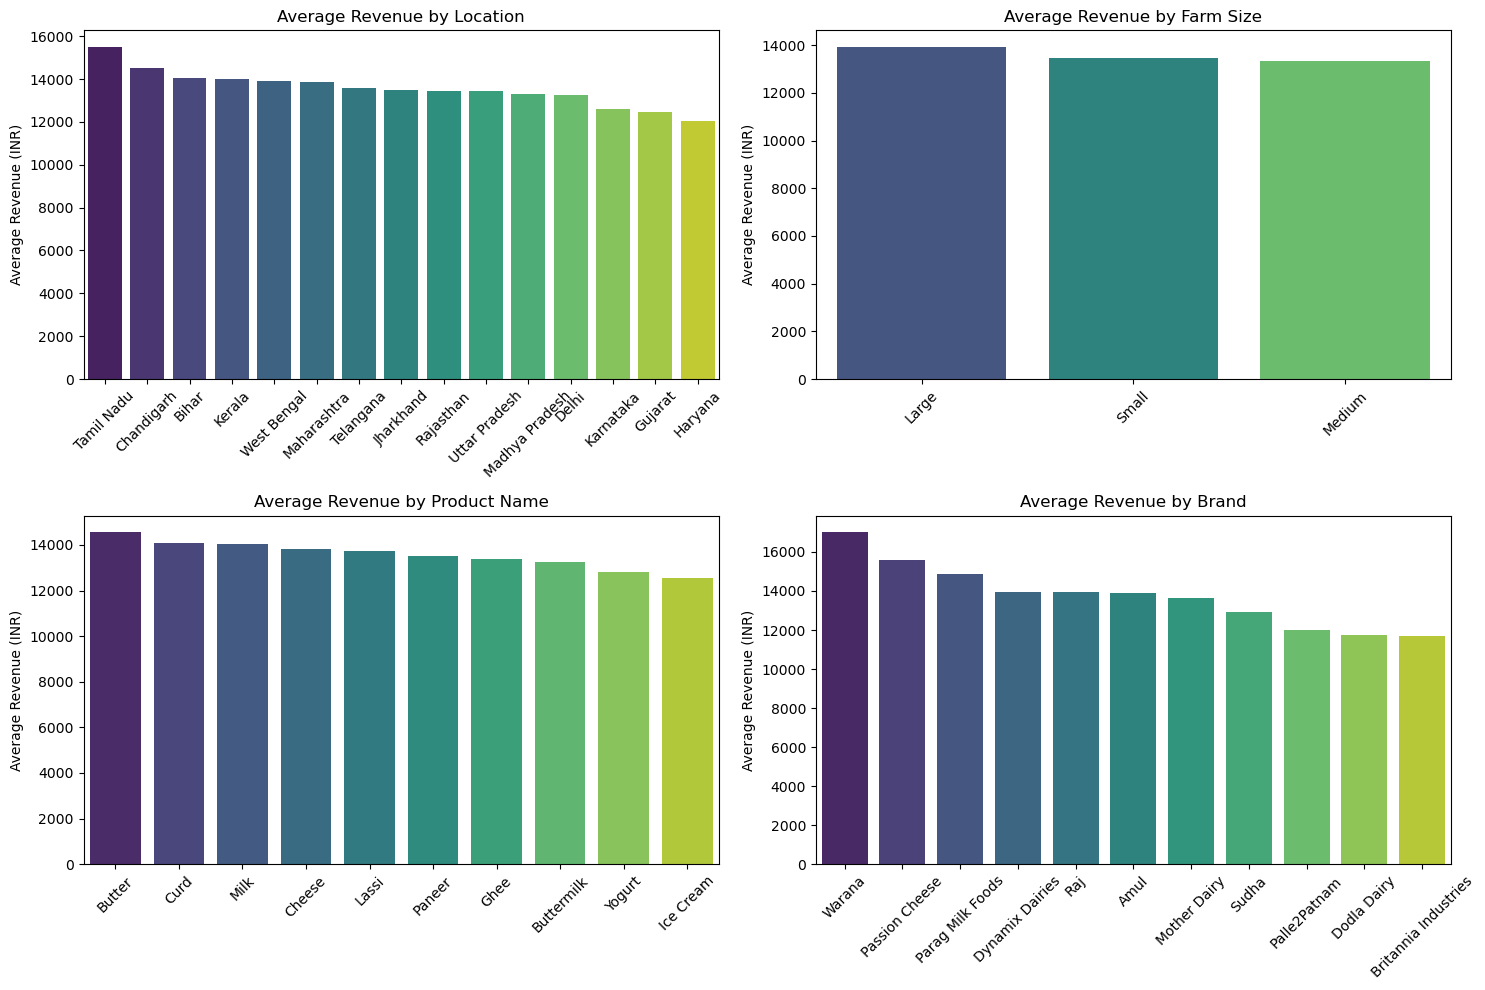

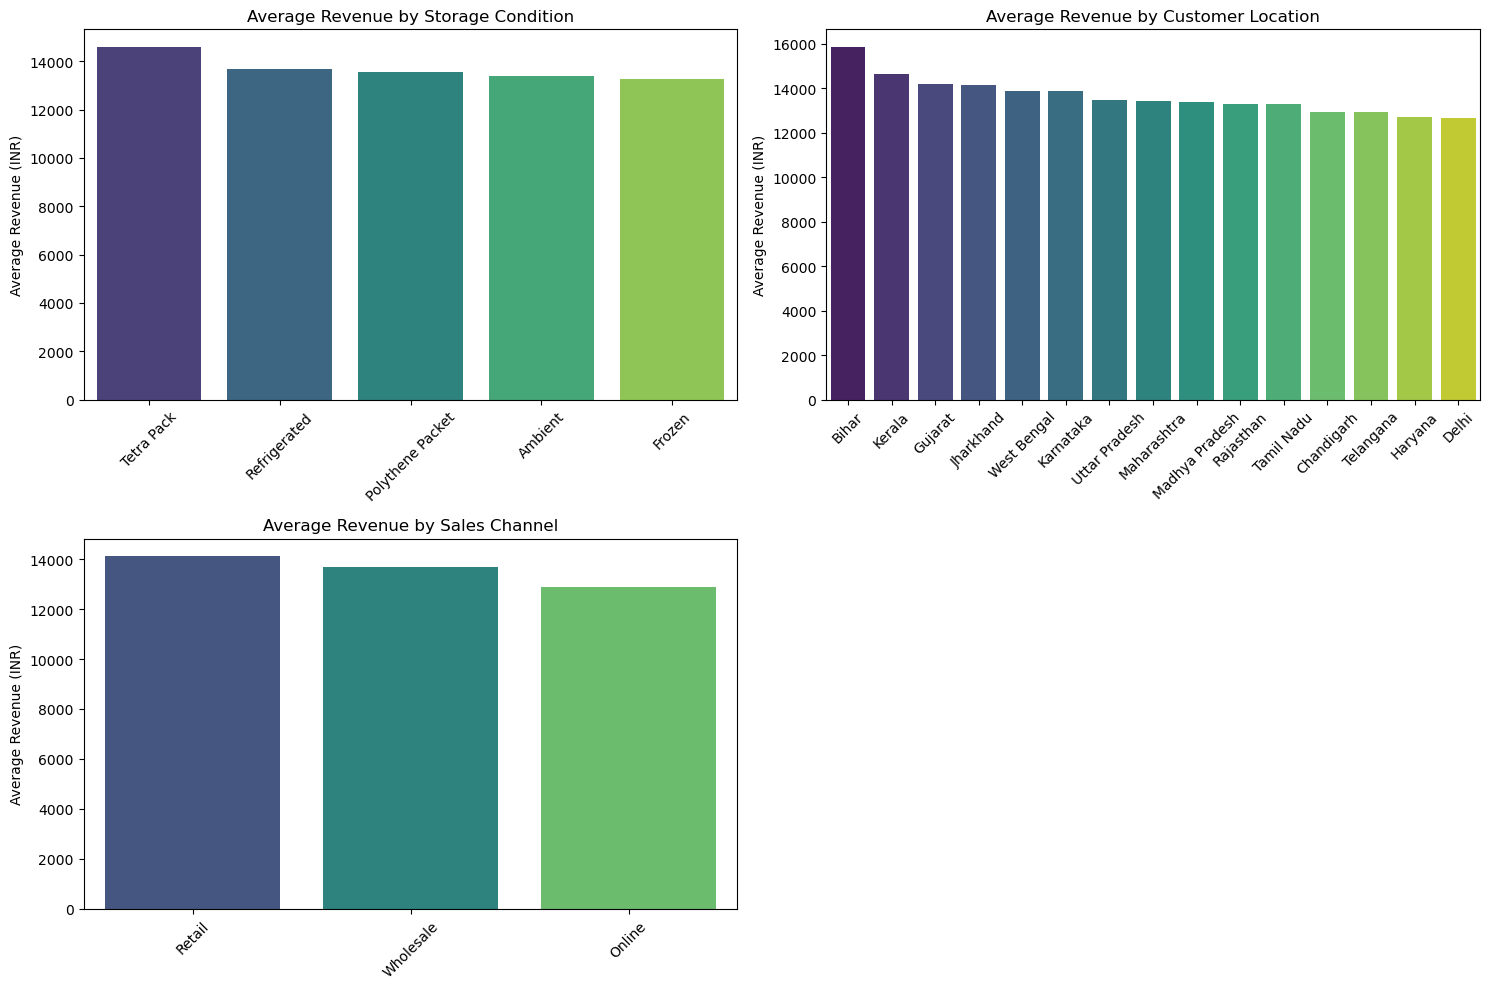

In [14]:
# Use all categorical columns
cat_to_plot = cat_cols  # from your earlier separation

# Plot 4 per figure (2x2 layout)
for start in range(0, len(cat_to_plot), 4):
    subset = cat_to_plot[start:start+4]
    plt.figure(figsize=(15, 10))

    for i, col in enumerate(subset, 1):
        plt.subplot(2, 2, i)

        # Compute mean revenue per category
        revenue_mean = (
            dairy_data.groupby(col)['Approx. Total Revenue(INR)']
            .mean()
            .sort_values(ascending=False)
        )

        # Updated Seaborn syntax to avoid FutureWarning
        sns.barplot(
            x=revenue_mean.index,
            y=revenue_mean.values,
            hue=revenue_mean.index,
            palette='viridis',
            legend=False
        )

        plt.title(f"Average Revenue by {col}")
        plt.xticks(rotation=45)
        plt.ylabel("Average Revenue (INR)")
        plt.xlabel("")

    plt.tight_layout()
    plt.show()

In [15]:
# Time-based feature extraction

# Convert to datetime if not already
dairy_data['Date'] = pd.to_datetime(dairy_data['Date'])
dairy_data['Production Date'] = pd.to_datetime(dairy_data['Production Date'])
dairy_data['Expiration Date'] = pd.to_datetime(dairy_data['Expiration Date'])

# Extract calendar-based features
dairy_data['Year'] = dairy_data['Date'].dt.year
dairy_data['Month'] = dairy_data['Date'].dt.month
dairy_data['Year_Quarter'] = dairy_data['Date'].dt.to_period('Q').astype(str)
dairy_data['Quarter'] = 'Q' + dairy_data['Date'].dt.quarter.astype(str)

# Quick check
dairy_data[['Year','Month', 'Year_Quarter', 'Quarter']].head()

,Year,Month,Year_Quarter,Quarter
0,2022,2,2022Q1,Q1
1,2021,12,2021Q4,Q4
2,2022,2,2022Q1,Q1
3,2019,6,2019Q2,Q2
4,2020,12,2020Q4,Q4


<Axes: xlabel='Month'>

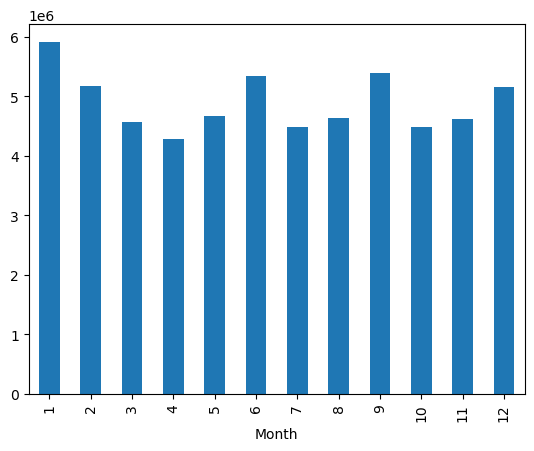

In [16]:
dairy_data.groupby('Month')['Approx. Total Revenue(INR)'].sum().plot(kind='bar')

<Axes: xlabel='Year'>

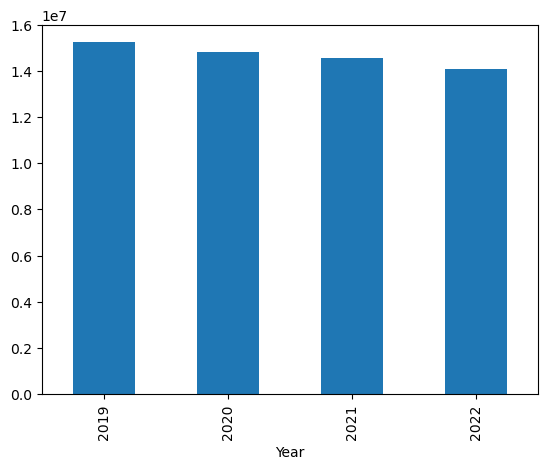

In [17]:
dairy_data.groupby('Year')['Approx. Total Revenue(INR)'].sum().plot(kind='bar')

<Axes: xlabel='Quarter'>

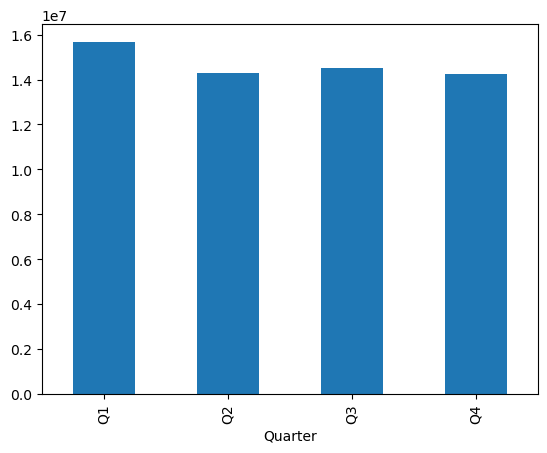

In [18]:
dairy_data.groupby('Quarter')['Approx. Total Revenue(INR)'].sum().plot(kind='bar')

<Axes: xlabel='Year_Quarter'>

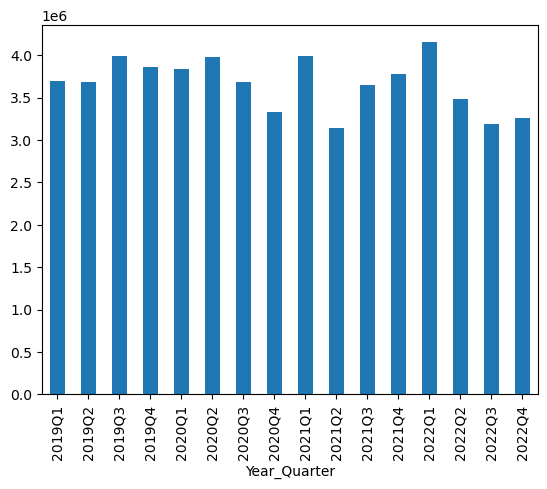

In [19]:
dairy_data.groupby('Year_Quarter')['Approx. Total Revenue(INR)'].sum().plot(kind='bar')

#### Aggregate raw dairy sales data into summarized form

In [20]:
# Aggregate raw dairy sales data into summarized form
agg_dict = {
    'Approx. Total Revenue(INR)': 'sum',
    'Quantity Sold (liters/kg)': 'sum',
    'Total Value': 'sum',
    'Quantity (liters/kg)': 'mean',
    'Price per Unit (sold)': 'mean',
    'Revenue_per_Unit': 'mean',
    'Price per Unit': 'mean',
    'Quantity in Stock (liters/kg)': 'mean',
    'Minimum Stock Threshold (liters/kg)': 'mean',
    'Reorder Quantity (liters/kg)': 'mean',
    'Shelf Life (days)': 'mean',
    'Total Land Area (acres)': 'mean',
    'Number of Cows': 'mean'
}

group_keys = [
    'Year', 'Quarter', 'Product Name', 'Brand', 
    'Sales Channel', 'Storage Condition', 'Customer Location'
]

dairy_data= dairy_data.groupby(group_keys).agg(agg_dict).reset_index()
dairy_data.head()

,Year,Quarter,Product Name,Brand,Sales Channel,Storage Condition,Customer Location,Approx. Total Revenue(INR),Quantity Sold (liters/kg),Total Value,Quantity (liters/kg),Price per Unit (sold),Revenue_per_Unit,Price per Unit,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Shelf Life (days),Total Land Area (acres),Number of Cows
0,2019,Q1,Butter,Amul,Online,Frozen,Rajasthan,10486.84,268,10588.3512,300.72,39.130,39.130,35.210,32.0,17.37,115.850,39.0,385.570,65.0
1,2019,Q1,Butter,Amul,Retail,Frozen,Karnataka,17627.66,214,83054.2641,486.07,56.615,56.615,57.515,378.5,80.74,90.515,36.5,523.725,39.0
2,2019,Q1,Butter,Amul,Retail,Frozen,Uttar Pradesh,2029.06,22,2755.9620,30.69,92.230,92.230,89.800,8.0,27.10,22.110,29.0,672.520,32.0
3,2019,Q1,Butter,Amul,Retail,Refrigerated,Bihar,10801.28,112,14090.5557,151.17,96.440,96.440,93.210,39.0,12.52,164.220,25.0,612.820,80.0
4,2019,Q1,Butter,Amul,Wholesale,Frozen,Jharkhand,23175.60,248,33849.7410,358.35,93.450,93.450,94.460,110.0,82.68,104.080,36.0,347.340,46.0


In [21]:
# Feature Engineering
dairy_data['Quantity_per_Cow'] = dairy_data['Quantity Sold (liters/kg)'] / dairy_data['Number of Cows']
dairy_data['Sales_Efficiency'] = dairy_data['Quantity Sold (liters/kg)'] / dairy_data['Quantity (liters/kg)']
dairy_data['Production_Density'] = dairy_data['Quantity (liters/kg)'] / dairy_data['Number of Cows']
dairy_data['Price_to_ShelfLife_Ratio'] = dairy_data['Price per Unit (sold)'] / dairy_data['Shelf Life (days)']
dairy_data['Reorder_Intensity'] = dairy_data['Reorder Quantity (liters/kg)'] / dairy_data['Quantity Sold (liters/kg)']
dairy_data['Production_to_ShelfLife'] = dairy_data['Quantity (liters/kg)'] / (dairy_data['Shelf Life (days)'])
dairy_data['Land_Productivity'] = dairy_data['Quantity (liters/kg)'] / dairy_data['Total Land Area (acres)']

### Step 4 : Inferential Statistics

Goal: Test whether certain **groups differ significantly** and identify which factors truly influence revenue and other business metrics.

#### Step 3.1 — ANOVA: Revenue by Brand

Goal:

check if average revenue differs significantly among different brands.

Hypotheses:

H₀ (Null): All brands have the same mean revenue.

H₁ (Alternative): At least one brand has a different mean revenue.

In [22]:
import scipy.stats as stats

# Group revenue by Brand
brand_groups = [group[target].values for name, group in dairy_data.groupby('Brand')]

# Run one-way ANOVA
f_stat, p_val = stats.f_oneway(*brand_groups)

print(f"ANOVA test for Revenue across Brands")
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_val:.5f}")

# Interpretation
if p_val < 0.05:
    print("✅ Significant difference found — Revenue varies by Brand.")
else:
    print("❌ No significant difference — Brand does not strongly affect Revenue.")

ANOVA test for Revenue across Brands
F-statistic: 1.572
P-value: 0.10826
❌ No significant difference — Brand does not strongly affect Revenue.


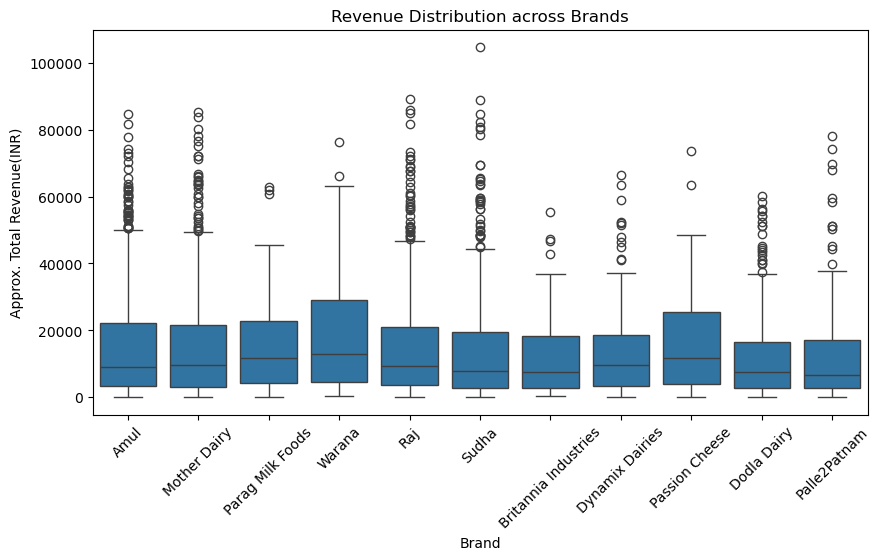

In [23]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Brand', y=target, data=dairy_data)
plt.title("Revenue Distribution across Brands")
plt.xticks(rotation=45)
plt.show()

Brand does not significantly affect total revenue — the sales performance looks fairly balanced across brands.

It suggests that other factors (like Sales Channel, Location, or Quantity Sold) might be stronger drivers of revenue.

### Step 4.2 — ANOVA Test for Sales Channel vs Revenue

Goal:

Check whether the average revenue differs across Retail, Wholesale, and Online channels.

Hypotheses:

H₀ (Null): Average revenue is the same across sales channels.

H₁ (Alternative): At least one sales channel has a different average revenue.

In [24]:
# Group revenue by Sales Channel
channel_groups = [group[target].values for name, group in dairy_data.groupby('Sales Channel')]

# Run one-way ANOVA
f_stat, p_val = stats.f_oneway(*channel_groups)

print(f"ANOVA test for Revenue across Sales Channels")
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_val:.5f}")

# Interpretation
if p_val < 0.05:
    print("✅ Significant difference found — Revenue varies by Sales Channel.")
else:
    print("❌ No significant difference — Sales Channel does not strongly affect Revenue.")

ANOVA test for Revenue across Sales Channels
F-statistic: 2.034
P-value: 0.13096
❌ No significant difference — Sales Channel does not strongly affect Revenue.


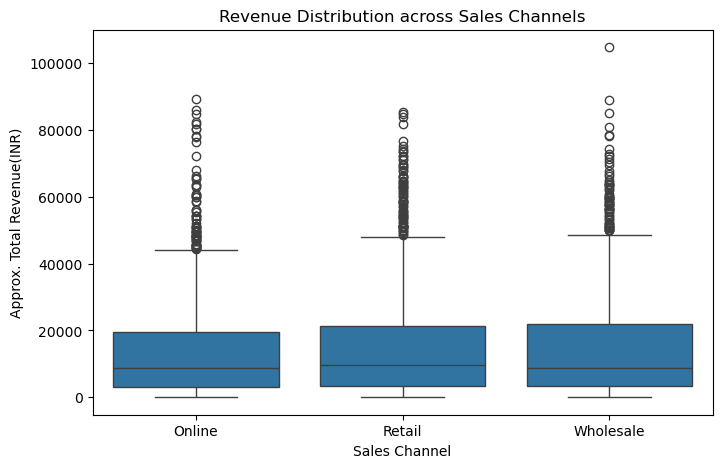

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Sales Channel', y=target, data=dairy_data)
plt.title("Revenue Distribution across Sales Channels")
plt.show()

Sales Channel does not appear to be a key driver of total revenue.

#### Step 4.3 — Chi-Square Test (Shelf Life vs Storage Condition)

Goal:

Check whether shelf life (e.g., short, medium, long duration) is associated with storage condition (e.g., refrigerated, frozen, etc.).

Hypotheses:

H₀ (Null): Shelf life and storage condition are independent.

H₁ (Alternative): Shelf life depends on storage condition (they are associated).

In [26]:
# Create a contingency table
contingency_table = pd.crosstab(dairy_data['Storage Condition'], dairy_data['Shelf Life (days)'])

# Run Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test: Shelf Life vs Storage Condition")
print(f"Chi2 Statistic: {chi2:.3f}")
print(f"P-value: {p:.5f}")
print(f"Degrees of Freedom: {dof}")

# Interpretation
if p < 0.05:
    print("✅ Significant association — Shelf Life depends on Storage Condition.")
else:
    print("❌ No significant association — Shelf Life is independent of Storage Condition.")

Chi-Square Test: Shelf Life vs Storage Condition
Chi2 Statistic: 9658.839
P-value: 0.00000
Degrees of Freedom: 796
✅ Significant association — Shelf Life depends on Storage Condition.


Key Insights

Volume (Quantity Sold) is the strongest driver of revenue.

Total Value (stock worth) also correlates highly — makes sense in sales context.

Price factors (per unit) influence revenue moderately but less than sales volume.

#### Step 5: Apply PCA

In [27]:
dairy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4037 entries, 0 to 4036
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year                                 4037 non-null   int32  
 1   Quarter                              4037 non-null   object 
 2   Product Name                         4037 non-null   object 
 3   Brand                                4037 non-null   object 
 4   Sales Channel                        4037 non-null   object 
 5   Storage Condition                    4037 non-null   object 
 6   Customer Location                    4037 non-null   object 
 7   Approx. Total Revenue(INR)           4037 non-null   float64
 8   Quantity Sold (liters/kg)            4037 non-null   int64  
 9   Total Value                          4037 non-null   float64
 10  Quantity (liters/kg)                 4037 non-null   float64
 11  Price per Unit (sold)         

In [28]:
# Select numeric columns (excluding target)
numeric_cols = dairy_data.select_dtypes(include=['int64', 'float64']).columns.drop('Approx. Total Revenue(INR)')
X = dairy_data[numeric_cols]

In [29]:
# Checks if feature matrix X has infinite values (+∞ or -∞)
np.isinf(X).sum()

Quantity Sold (liters/kg)              0
Total Value                            0
Quantity (liters/kg)                   0
Price per Unit (sold)                  0
Revenue_per_Unit                       0
Price per Unit                         0
Quantity in Stock (liters/kg)          0
Minimum Stock Threshold (liters/kg)    0
Reorder Quantity (liters/kg)           0
Shelf Life (days)                      0
Total Land Area (acres)                0
Number of Cows                         0
Quantity_per_Cow                       0
Sales_Efficiency                       0
Production_Density                     0
Price_to_ShelfLife_Ratio               0
Reorder_Intensity                      0
Production_to_ShelfLife                0
Land_Productivity                      0
dtype: int64

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

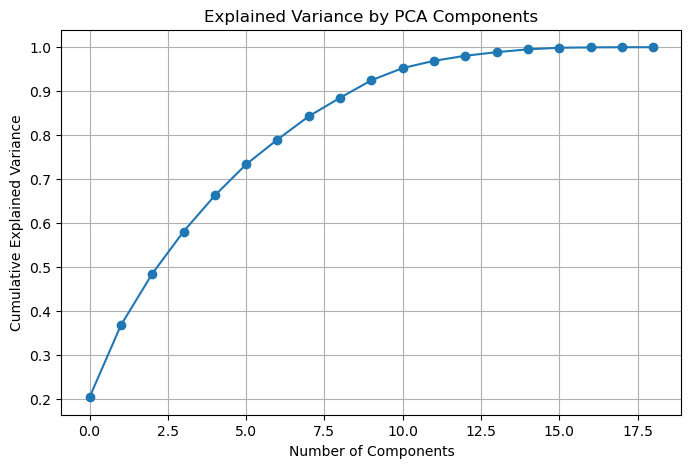

In [32]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

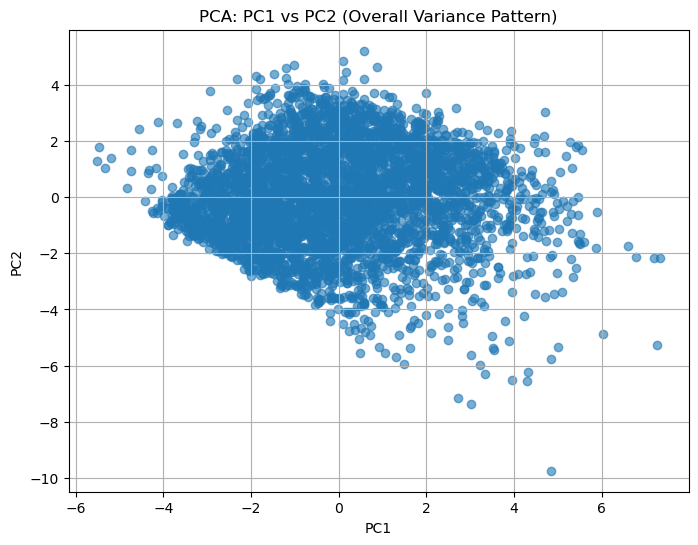

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: PC1 vs PC2 (Overall Variance Pattern)')
plt.grid(True)
plt.show()

<Axes: >

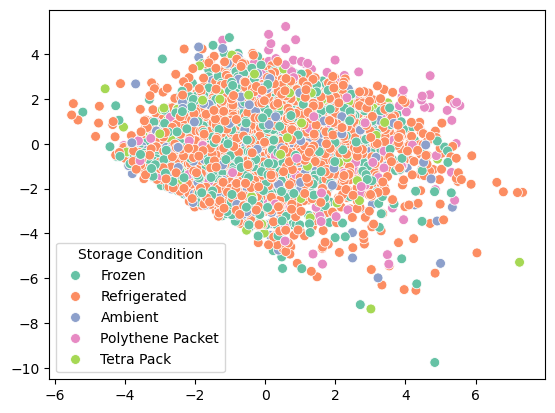

In [34]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=dairy_data['Storage Condition'], palette='Set2', s=50)

In [35]:
# Check PCA component loadings
pca_components = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
pca_components.head(2)

,Quantity Sold (liters/kg),Total Value,Quantity (liters/kg),Price per Unit (sold),Revenue_per_Unit,Price per Unit,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Shelf Life (days),Total Land Area (acres),Number of Cows,Quantity_per_Cow,Sales_Efficiency,Production_Density,Price_to_ShelfLife_Ratio,Reorder_Intensity,Production_to_ShelfLife,Land_Productivity
PC1,0.293896,0.444635,0.333401,0.321981,0.321981,0.321632,0.156945,0.002307,0.000639,-0.037880,-0.017745,-0.109753,0.290241,0.108309,0.289542,0.139718,-0.133481,0.161087,0.111592
PC2,-0.281813,0.035809,-0.281522,0.424435,0.424435,0.423637,-0.090888,0.013812,0.022875,-0.013093,0.043558,0.157206,-0.323985,-0.123695,-0.307908,0.134458,0.118687,-0.067072,-0.113097


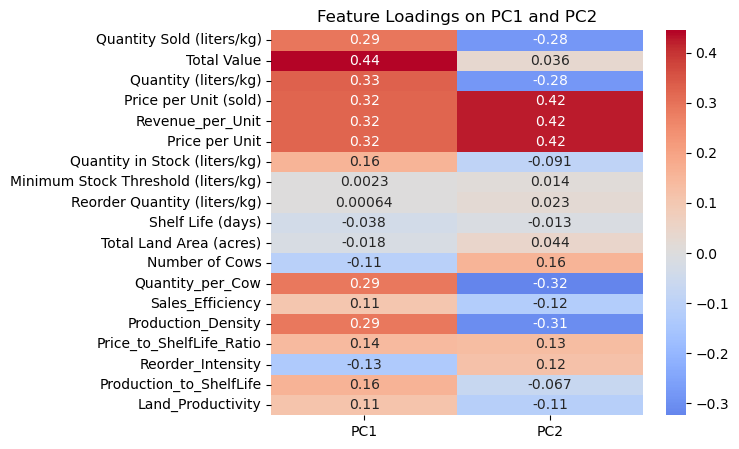

In [36]:
loadings = pd.DataFrame(
    pca.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=numeric_cols
)
plt.figure(figsize=(6,5))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Loadings on PC1 and PC2')
plt.show()


### PCA reveals that:

The dataset’s main drivers of variance are sales volume, pricing, and efficiency metrics, not categorical factors such as brand or storage condition.

Production and pricing dynamics explain nearly all the variance, making them the primary levers of revenue performance.

Dimensionality can safely be reduced without substantial information loss, simplifying downstream model training.

### Step 6: Coorelation analysis

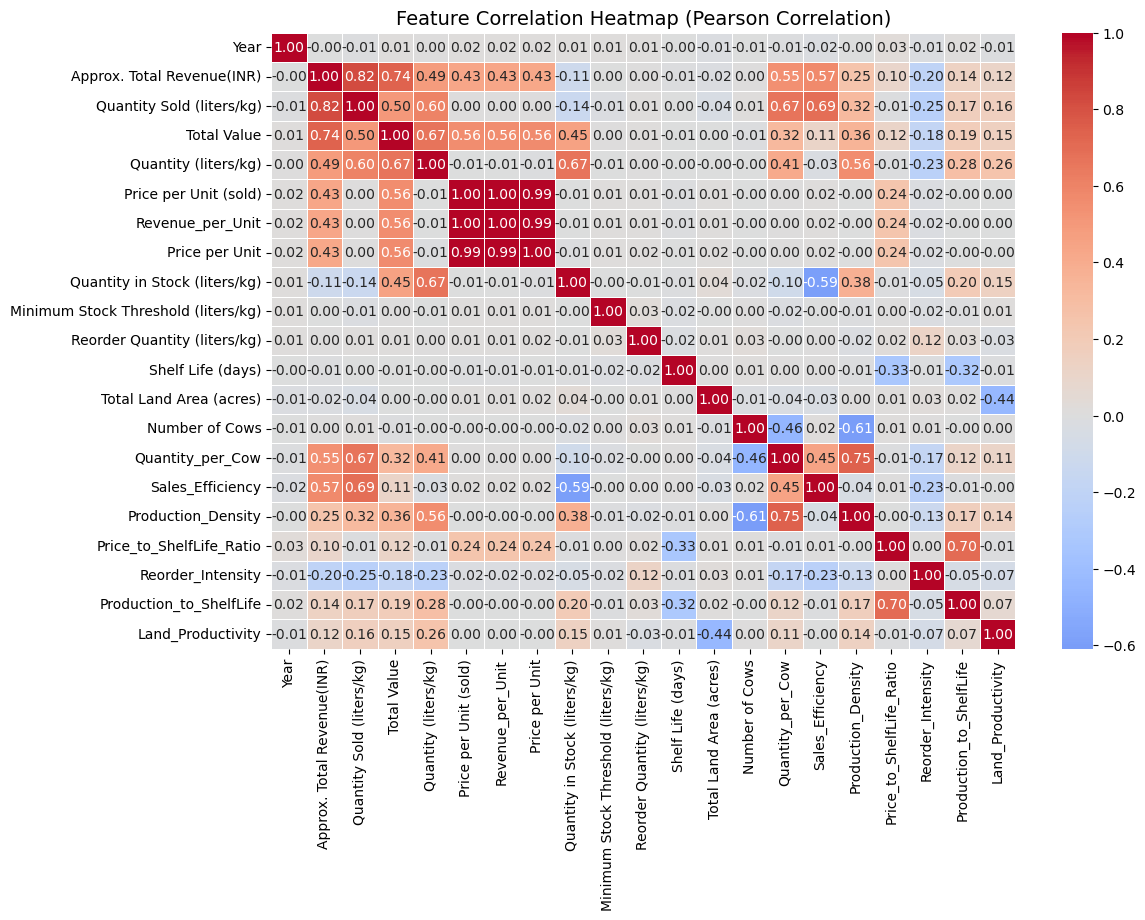

In [37]:
# Select only numeric features
numeric_df = dairy_data.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Heatmap (Pearson Correlation)", fontsize=14)
plt.show()

C:\Users\WEYAN52\AppData\Local\Temp\ipykernel_38460\2078791872.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')


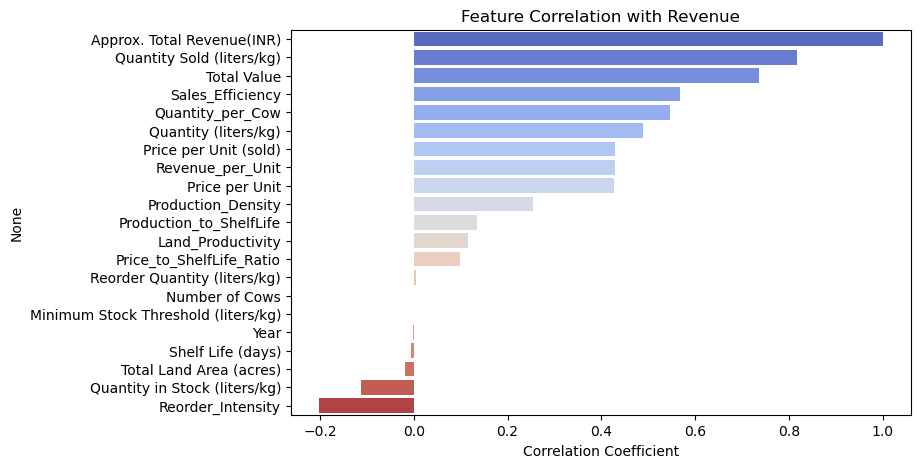

In [38]:
target_corr = corr_matrix['Approx. Total Revenue(INR)'].sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title("Feature Correlation with Revenue")
plt.xlabel("Correlation Coefficient")
plt.show()

### Step 7: Drop the identified 

During the feature refinement stage, both multicollinearity and correlation with the target variable were evaluated.

1️⃣ Highly correlated / formula-based variables (e.g., Quantity Sold (liters/kg), Price per Unit (sold), Revenue_per_Unit, Total Value, and Quantity (liters/kg)) were removed because they are mathematically derived from each other or from the target.
These could cause data leakage and distort model interpretation, so excluding them improves the model’s reliability.

2️⃣ Moderately correlated variables (r < 0.8) were retained.
Such relationships are natural in business data (e.g., efficiency ratios, production density, land productivity) and still provide independent insights into revenue drivers.
This level of correlation does not harm model stability, especially for tree-based algorithms like Random Forest.

3️⃣ Weakly correlated features were also retained intentionally.
Even if their linear correlation with revenue is low, they may still contribute non-linear or interaction effects that improve predictive performance — particularly in ensemble or non-linear models.
Keeping them ensures no potentially useful information is lost prematurely.

In [39]:
# Define the columns to drop (formula-based + highly collinear)
cols_to_drop = [
    'Quantity Sold (liters/kg)',
    'Price per Unit (sold)',
    'Price per Unit',
    'Revenue_per_Unit',
    'Total Value',
    'Quantity (liters/kg)'
]

# Drop safely from both train and test sets
dairy_data = dairy_data.drop(columns=cols_to_drop, errors='ignore')

# Confirm the result
dairy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4037 entries, 0 to 4036
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year                                 4037 non-null   int32  
 1   Quarter                              4037 non-null   object 
 2   Product Name                         4037 non-null   object 
 3   Brand                                4037 non-null   object 
 4   Sales Channel                        4037 non-null   object 
 5   Storage Condition                    4037 non-null   object 
 6   Customer Location                    4037 non-null   object 
 7   Approx. Total Revenue(INR)           4037 non-null   float64
 8   Quantity in Stock (liters/kg)        4037 non-null   float64
 9   Minimum Stock Threshold (liters/kg)  4037 non-null   float64
 10  Reorder Quantity (liters/kg)         4037 non-null   float64
 11  Shelf Life (days)             

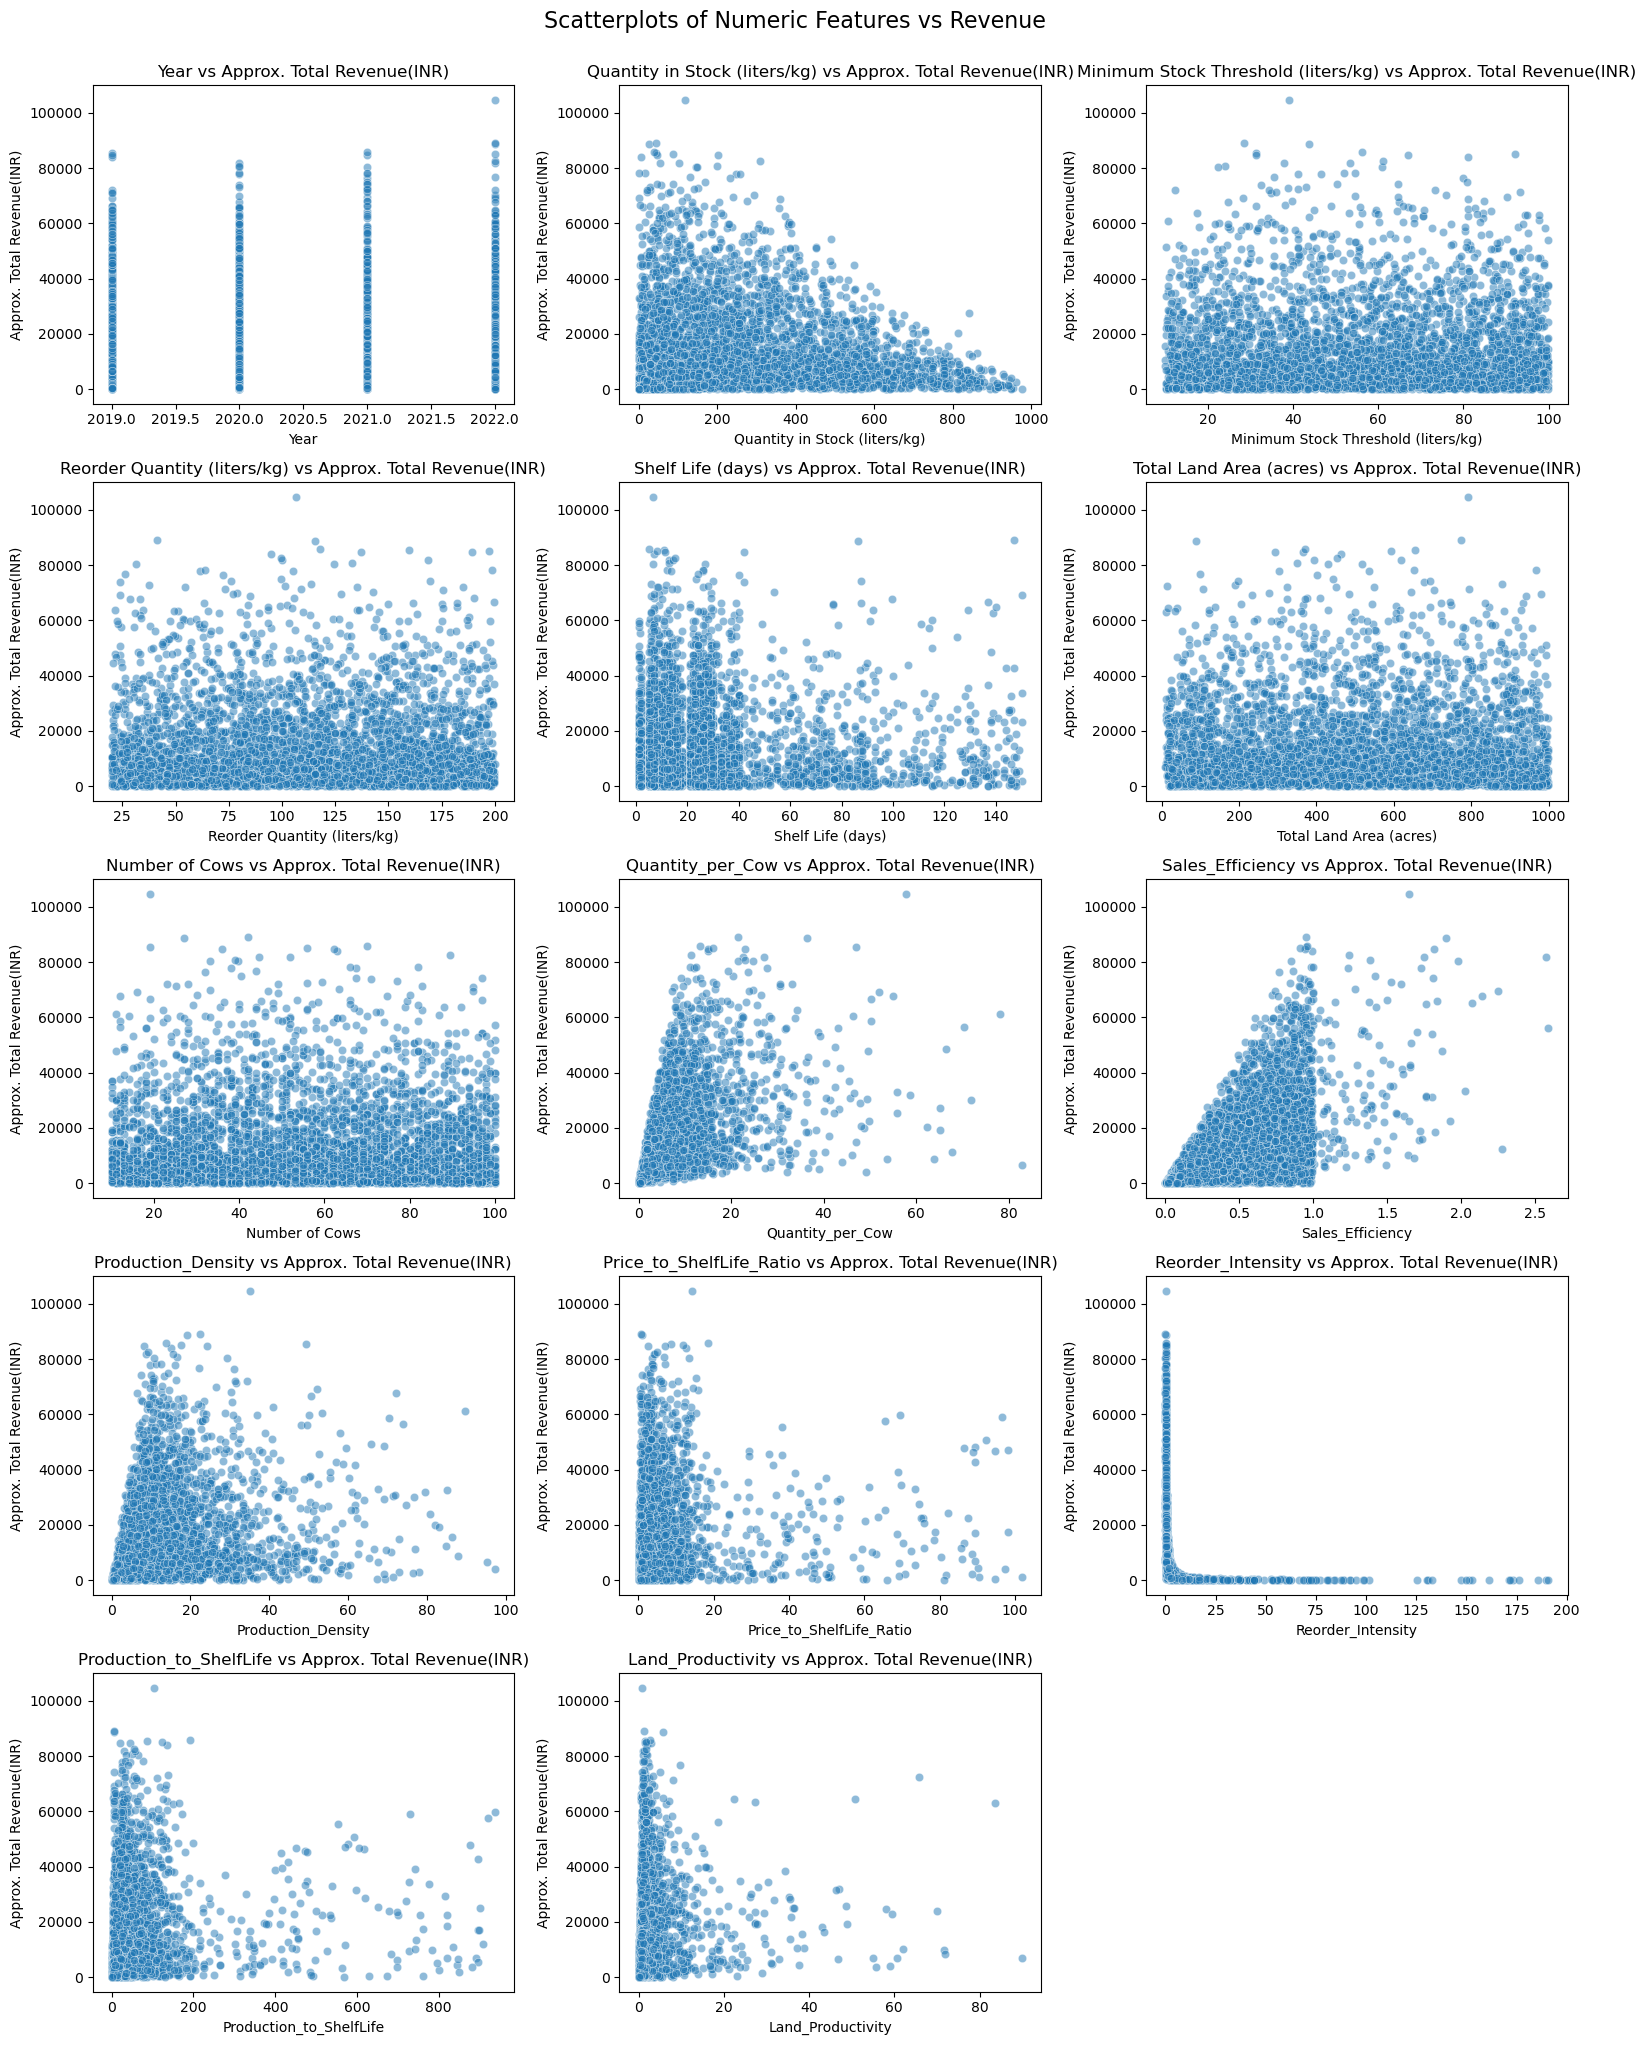

In [40]:
# Select numeric features (exclude target)
num_features = [col for col in dairy_data.select_dtypes(include=['number']).columns if col != target]

# Auto calculate rows and columns for subplots
cols = 3
rows = math.ceil(len(num_features) / cols)

plt.figure(figsize=(16, rows * 4))

for i, col in enumerate(num_features, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(data=dairy_data, x=col, y=target, alpha=0.5)
    plt.title(f"{col} vs {target}")
    plt.tight_layout()

plt.suptitle("Scatterplots of Numeric Features vs Revenue", fontsize=16, y=1.02)
plt.show()

### Step 8: Save the file

In [41]:
# Save the processed data
datapath = './data'  # or any folder you want
filename = 'dairy_data_features.csv'

# Make sure the folder exists
import os
os.makedirs(datapath, exist_ok=True)

# Save the file
dairy_data.to_csv(os.path.join(datapath, filename), index=False)

print(f"✅ File saved successfully at: {os.path.join(datapath, filename)}")

✅ File saved successfully at: ./data\dairy_data_features.csv


### EDA Summary:

1️⃣ Data Preparation:

Aggregated duplicate records by key categorical dimensions (Year, Quarter, Product, Brand, Channel, Storage Condition, Location).

Added Year and Quarter for time-based analysis.

2️⃣ Feature Engineering:

Created new business metrics capturing production, efficiency, and stock behavior:
Production_Efficiency, Sales_Efficiency, Land_Productivity, Stock_Sell_Through, Reorder_to_Stock_Ratio, and Production_to_ShelfLife.

3️⃣ Relationship Analysis:

Conducted correlation and scatterplot analysis between numeric features and revenue.

Found strong relationships for Quantity Sold, Sales_Efficiency, and Quantity_per_Cow, while Shelf Life and Reorder_Intensity showed weak or negative correlations.

5️⃣ PCA Insights:

PCA showed that around 10 components explain >95% of data variance.

The main sources of variation were sales volume, pricing, and efficiency metrics, not categorical attributes.

Confirmed that numerical performance indicators dominate the revenue pattern.

4️⃣ Feature Reduction:

Removed mathematically dependent columns (Quantity Sold, Price per Unit, Revenue_per_Unit, Total Value, Quantity) to avoid multicollinearity and data leakage.

Retained moderately and weakly correlated variables to capture possible non-linear relationships.

### Conclusion:
Revenue in the dairy dataset is primarily driven by production quantity and efficiency metrics, rather than categorical factors.
The dataset is now clean, feature-engineered, and ready for predictive modeling using both Linear Regression and Random Forest.